# Face Generation using GAN   
I built a generative adversarial network (GAN) to generate face, the network is trained on [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset    
       
Technically GANs consist of a constant push between two networks (thus “adversarial”): a generator (G) and discriminator (D). Given a set of training examples (such as images), we can imagine that there is an underlying distribution (x) that governs them. With GANs, G will generate outputs and D will decide if they come from the same distribution of the the training set or not.    
![](./img/gan.png)   
( a simple GAN model )

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import tensorflow as tf

%matplotlib inline

In [2]:
dataset_path = '/input'
img_paths = [glob(os.path.join(dataset_path, 'img_align_celeba/*.jpg')) for path in os.listdir(dataset_path)]

### Define some help function to load the images

In [3]:
def get_image(image_path, width, height):
    image = plt.imread(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        i = (image.shape[0] - face_width) // 2
        j = (image.shape[1] - face_height) // 2
        image = image[i:i+face_width, j:j+face_height]
        image = cv2.resize(image, (width, height))

    return image


def get_batch(image_files, width, height):
    data_batch = np.array(
        [get_image(sample_file, width, height) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

In [4]:
img_paths = img_paths[0]

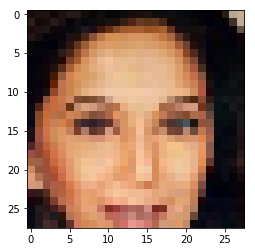

In [5]:
img = get_image(img_paths[0], 28, 28)
plt.imshow(img)

## Build the GAN   


### Input Placeholder   
In this function we'll get the real input placeholder **inputs_real** and fake input placeholder **inputs_z**

In [6]:
def get_input(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    
    return inputs_real, inputs_z

### Define the Generator   
The generator should return 28x28x3 images    
the architecture of generator is shown below
![]()    
And we should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.    
![]()

In [7]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, output_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

### Define the Discriminator  
It's a convolutional classifier. The input to the discriminator are 32x32x3 tensors/images. I add a few convolutional layers, then a fully connected layer for the output. 

In [8]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

### Calculate the loss

In [9]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

### Optimizer

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

### Get the output during training

In [11]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, reuse=True, training=False),
        feed_dict={input_z: example_z})
    plt.figure()
    plt.imshow(samples[0])
    plt.show()

## Build the Model and Train

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_paths, data_shape):
    image_channels = 3
        
    image_width = data_shape[0]
    image_height = data_shape[1]
    
    input_real, input_z = get_input(image_width, image_height, image_channels, z_dim)    
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_num = 0
    steps = 0
    samples, losses = [], []
    
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(data_paths, batch_size):
                # Sample random noise for G
                
                # Scale images between -1 and 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                batch_num += 1
                steps += 1
                
                if (batch_num%100 == 0):
                    show_generator_output(sess=sess,
                                          input_z=input_z,
                                          n_images=1,
                                          out_channel_dim=image_channels)
            
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})

                if (steps%20 == 0):
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))
                
        plt.plot(losses)

In [13]:
def get_batches(data_path, batch_size):
    IMAGE_MAX_VALUE = 255

    current_index = 0
    while current_index + batch_size <= len(data_path):
        data_batch = get_batch(data_path[current_index:current_index + batch_size], 28, 28)
        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5

Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 28.8270
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 2.5519
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.5964


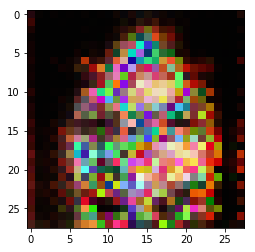

Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 1.7212
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 2.0355... Generator Loss: 7.7239
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 2.3995... Generator Loss: 4.3210


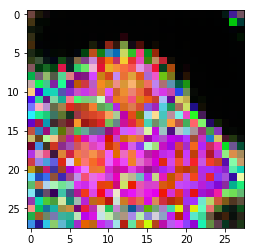

Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 2.4393... Generator Loss: 3.5340
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 2.0069... Generator Loss: 0.2389
Epoch 1/1... Discriminator Loss: 2.1213... Generator Loss: 4.8527


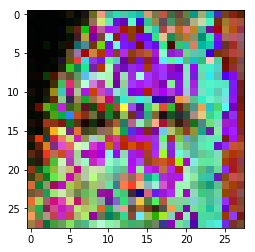

Epoch 1/1... Discriminator Loss: 3.1906... Generator Loss: 0.0953
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 2.1366... Generator Loss: 0.1734
Epoch 1/1... Discriminator Loss: 1.9688... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 1.4889


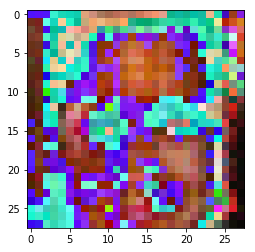

Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 2.1779... Generator Loss: 0.1823
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.5462


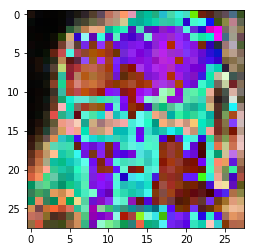

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.7693... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 1.9684... Generator Loss: 0.6300


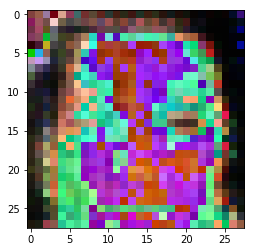

Epoch 1/1... Discriminator Loss: 1.9188... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.5926


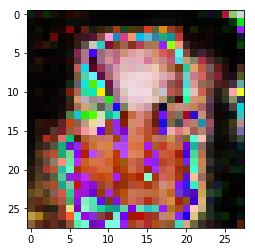

Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.6259... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 2.7787
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.4001


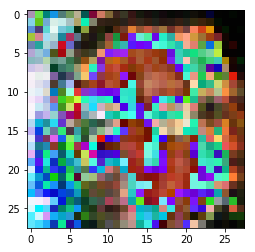

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.8178
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 2.3262


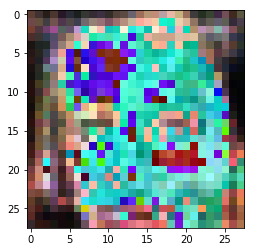

Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 2.3288
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.7860
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 0.9891


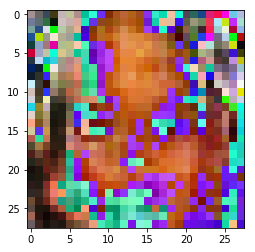

Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 2.1573
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 2.0028... Generator Loss: 0.3056


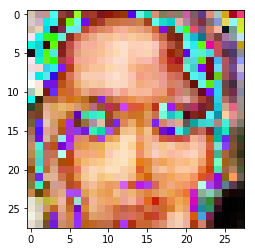

Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 2.7120
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.3351
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.4736


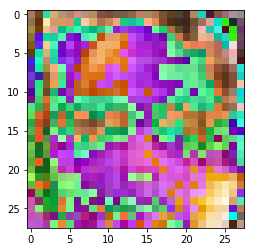

Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 1.3861


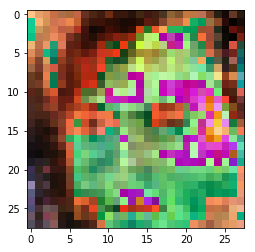

Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.7552... Generator Loss: 0.3366
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 2.5128... Generator Loss: 1.8266


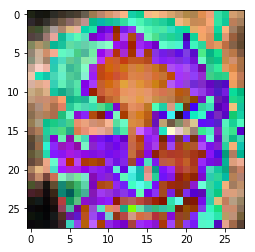

Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9673


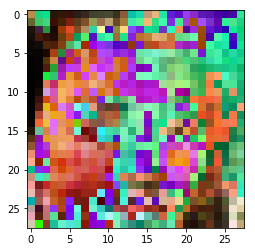

Epoch 1/1... Discriminator Loss: 2.5592... Generator Loss: 0.1546
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.8023... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 2.0286... Generator Loss: 0.2731
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 1.0004


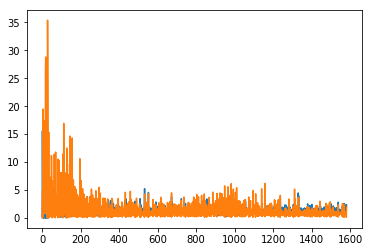

In [14]:
batch_size = 128
z_dim = 200
learning_rate = 0.002
beta1 = 0.5

epochs = 1

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, img_paths, [28, 28])